In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn-v0_8-darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
376,0,98,82,15,84,25.2,0.299,22,0
37,9,102,76,37,0,32.9,0.665,46,1
699,4,118,70,0,0,44.5,0.904,26,0
420,1,119,88,41,170,45.3,0.507,26,0
396,3,96,56,34,115,24.7,0.944,39,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Can minimum value of below listed columns be zero (0)?
#### After doing some research I found that on these columns, a value of zero does not make sense and thus indicates missing value.

#### 1- BloodPressure
#### 2- SkinThickness
#### 3- BMI
### So I'm going to replace all those zeros with NAN
#### Note : a value of zero in the insulin & glocose is not normal but acceptable

In [6]:
cols = ['BloodPressure','SkinThickness','BMI']

df[cols] = df[cols].replace(0,np.NaN)

## Splitting the data

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size= 0.2, random_state= 42)

## Cleaning train data

In [8]:
train.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                24
SkinThickness               176
Insulin                       0
BMI                           7
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

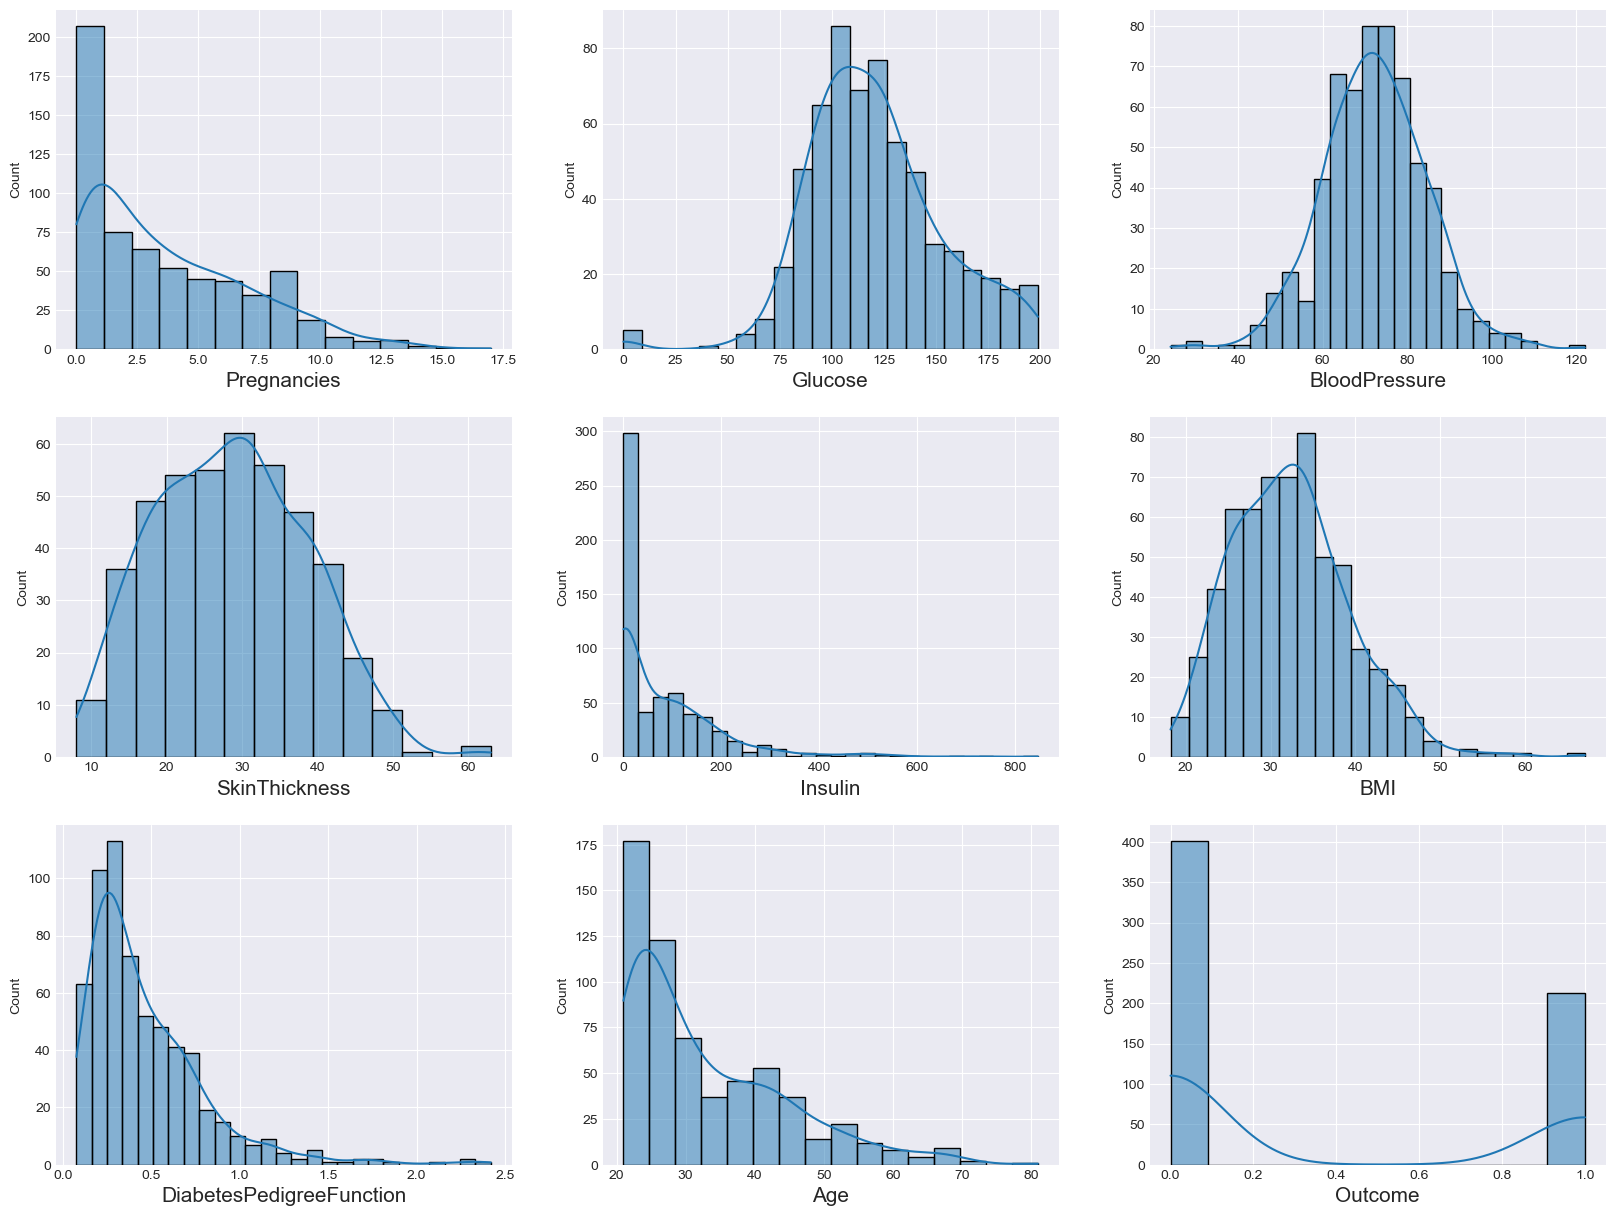

In [9]:
plt.figure(figsize = (20,15))
for i,col in enumerate(train):
    plt.subplot(3,3,i+1)
    sns.histplot(data = train, x=col, kde=True)
    plt.xlabel(col, fontsize = 15)
    plt.xticks(fontsize = 10)

#### I decided to fill the missing values using the iterative_imputer model with RandomForest Regressor from sklearn

## Iterative_imputer 

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(estimator= RandomForestRegressor(n_estimators=100), max_iter=10,random_state=42)
imputed_train = imp.fit_transform(train)

In [12]:
train = pd.DataFrame(imputed_train, columns = train.columns)

In [13]:
train.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### Some values seems to be high compared to the mean and median so I will plot these outliers

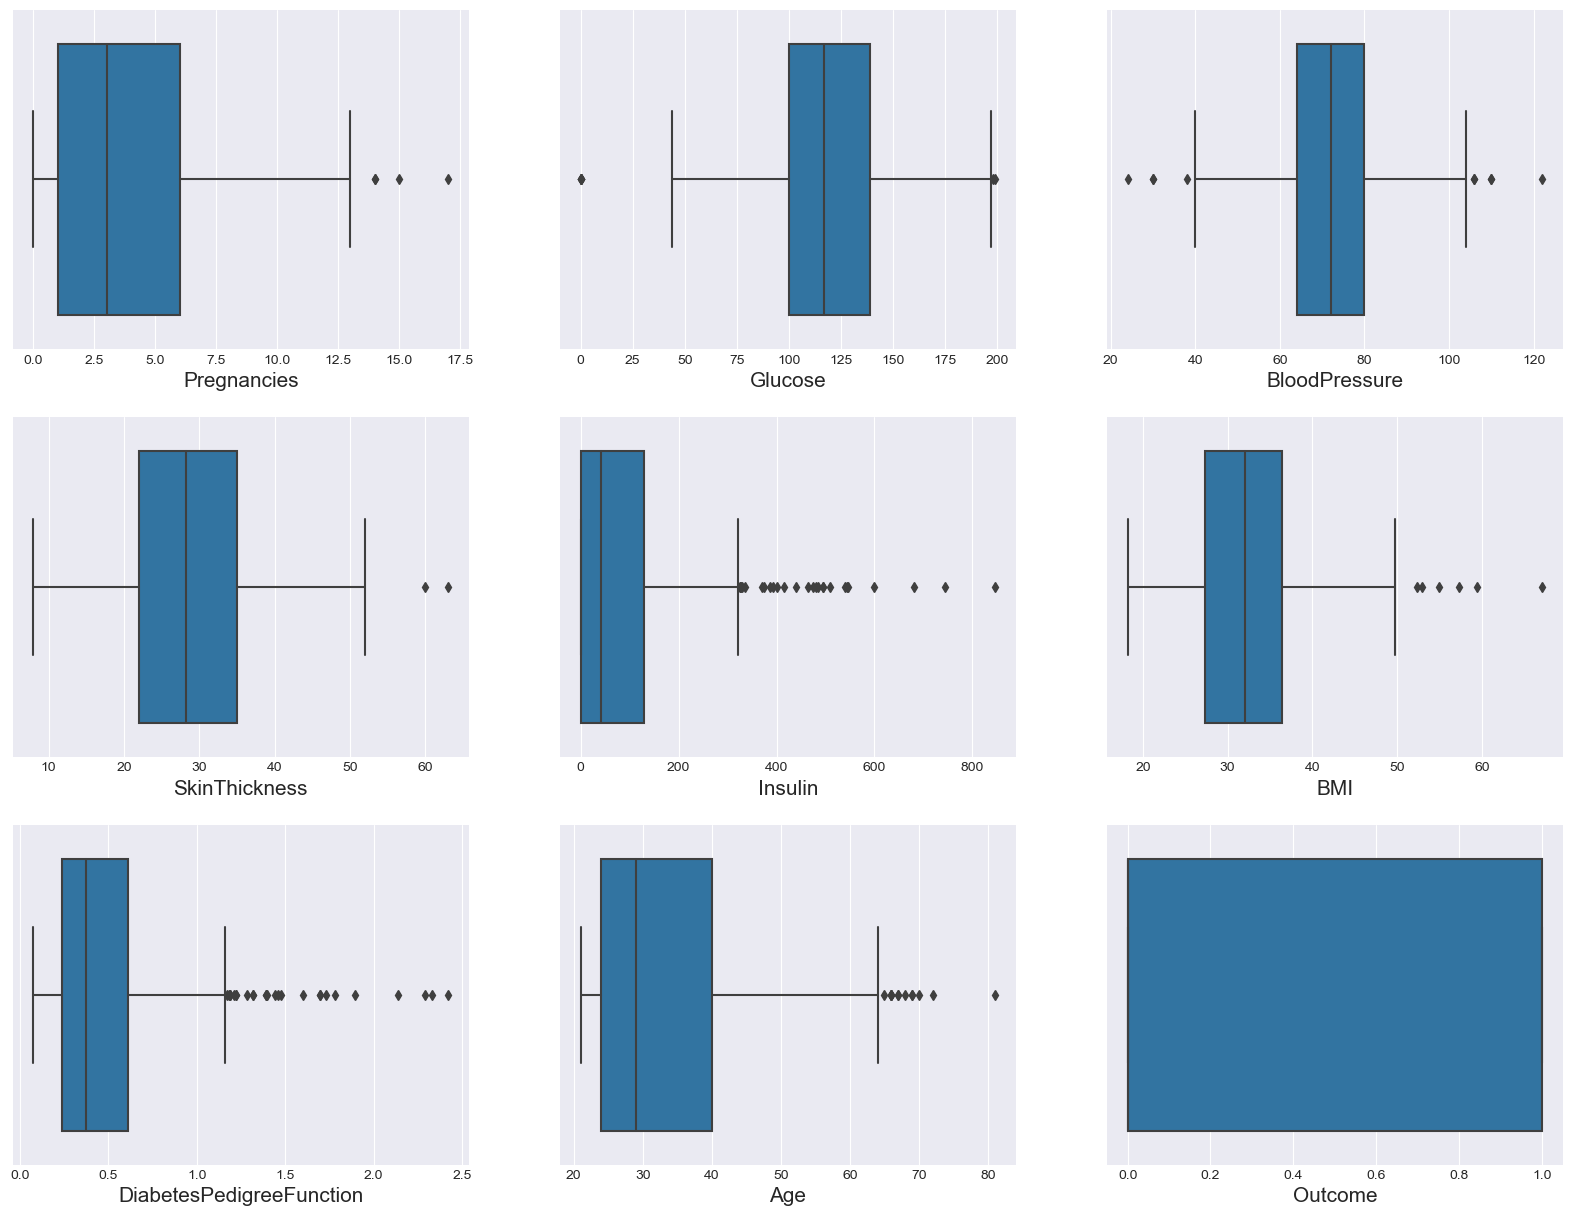

In [14]:
plt.figure(figsize=(20,15))
for i,col in enumerate(train):
    plt.subplot(3,3,i+1)
    sns.boxplot(data = train,x=col)
    plt.xlabel(col, fontsize=15)
    plt.xticks(fontsize=10)

In [15]:
def detect_outliers(df):
    outliers= pd.DataFrame(columns=["Feature","Num of Outliers","Handled?"])
    for col in df.columns:
        #Return values at the given quantile
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - (1.5*iqr)
        fence_high = q3 + (1.5*iqr)
        N_O_O = df.loc[(df[col] < fence_low) | (df[col] > fence_high)].shape[0]
                   
        df.loc[(df[col] < fence_low),col] = fence_low
        df.loc[(df[col] > fence_high),col] = fence_high
        #let's fix them
        outliers = outliers.append({'Feature': col, "Num of Outliers": N_O_O ,"Handled?": df[col].all() < fence_high},ignore_index=True)
    return outliers

In [16]:
detect_outliers(train)

,Feature,Num of Outliers,Handled?
0,Pregnancies,4,True
1,Glucose,7,True
2,BloodPressure,9,True
3,SkinThickness,2,True
4,Insulin,26,True
5,BMI,6,True
6,DiabetesPedigreeFunction,26,True
7,Age,13,True
8,Outcome,0,True


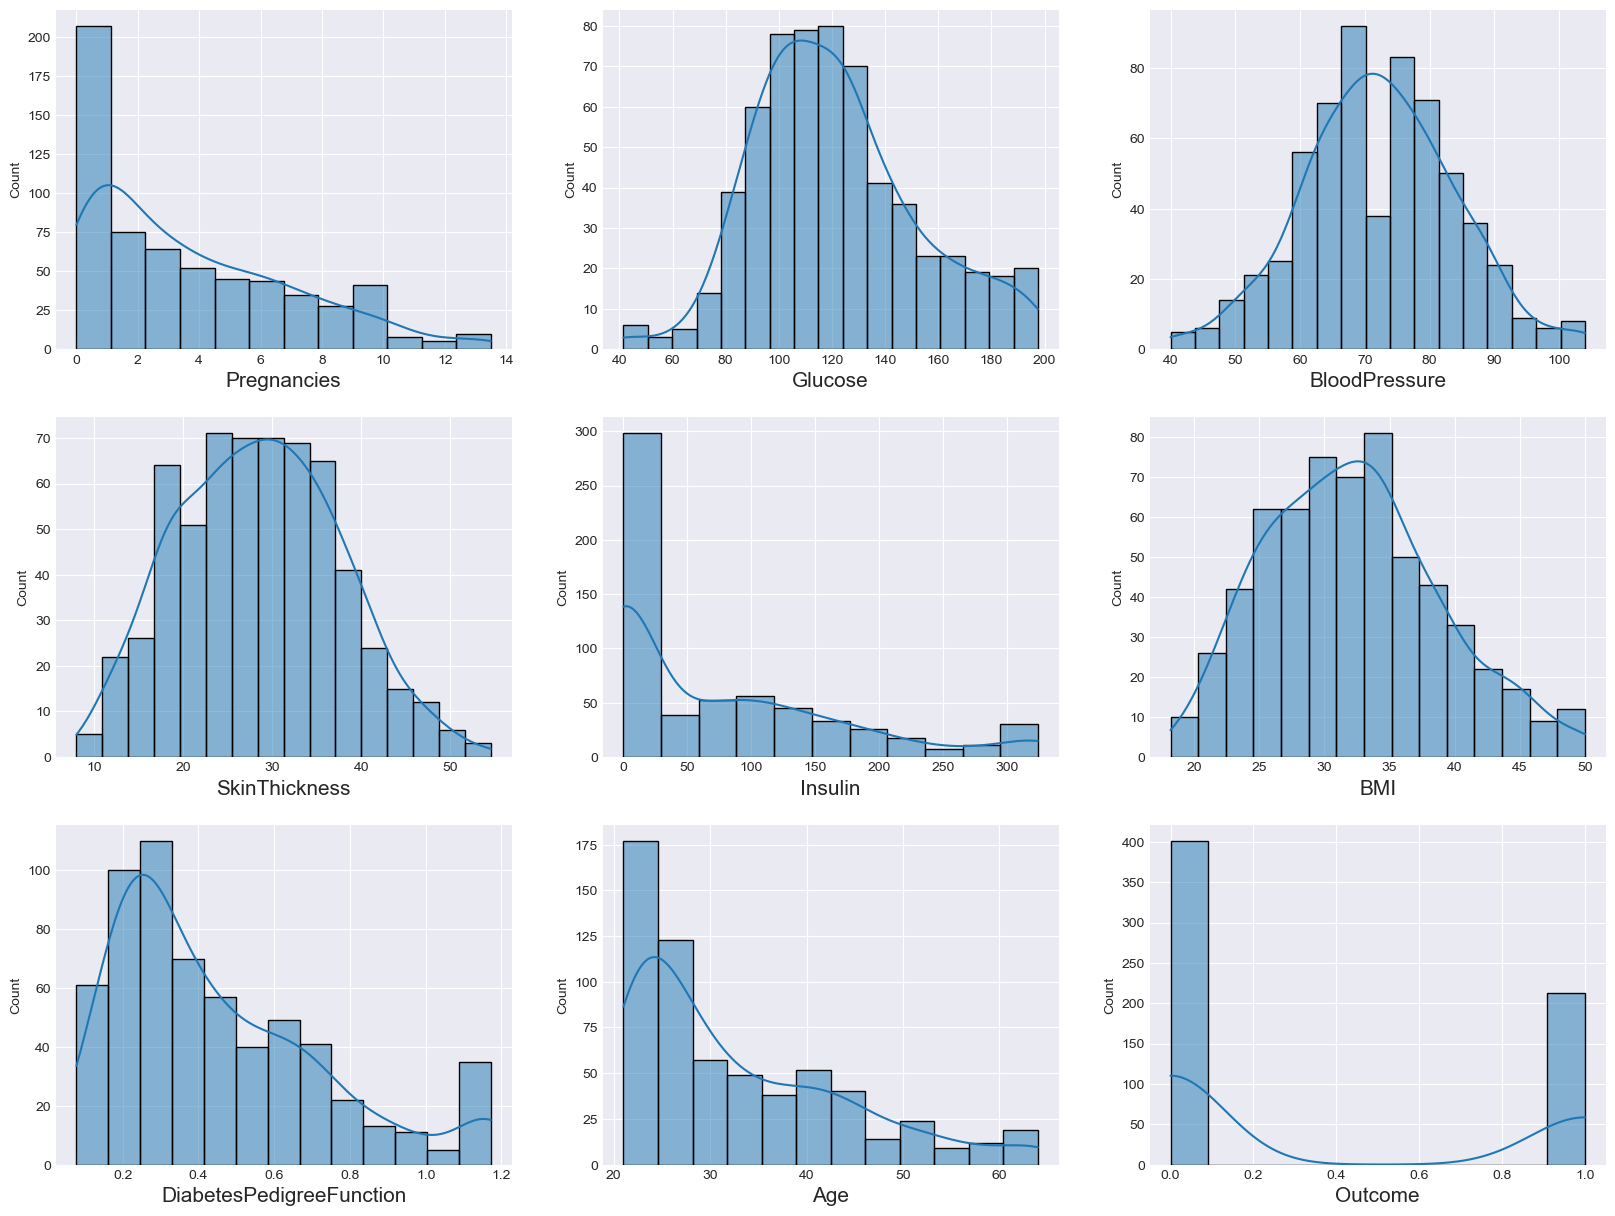

In [17]:
plt.figure(figsize = (20,15))
for i,col in enumerate(train):
    plt.subplot(3,3,i+1)
    sns.histplot(data = train, x=col, kde=True)
    plt.xlabel(col, fontsize = 15)
    plt.xticks(fontsize = 10)

#### It seems that the outliers in the pregnancies were set to 13.5 so i will set them back to 13 because 13.5 is not possible

In [18]:
train.loc[train['Pregnancies'] > 13, 'Pregnancies'] = 13

In [19]:
train['Pregnancies'].value_counts()

1.0     116
0.0      91
2.0      75
3.0      64
4.0      52
5.0      45
6.0      44
7.0      35
8.0      28
9.0      22
10.0     19
13.0     10
11.0      8
12.0      5
Name: Pregnancies, dtype: int64

## Cleaning test data

#### I'll repeat what i did with the train data but the imputations will be from the train data to prevent data lekage

In [20]:
test.isnull().sum()

Pregnancies                  0
Glucose                      0
BloodPressure               11
SkinThickness               51
Insulin                      0
BMI                          4
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64

### Iterative_imputer

In [21]:
imputed_test = imp.transform(test)
test = pd.DataFrame(imputed_test, columns = test.columns)

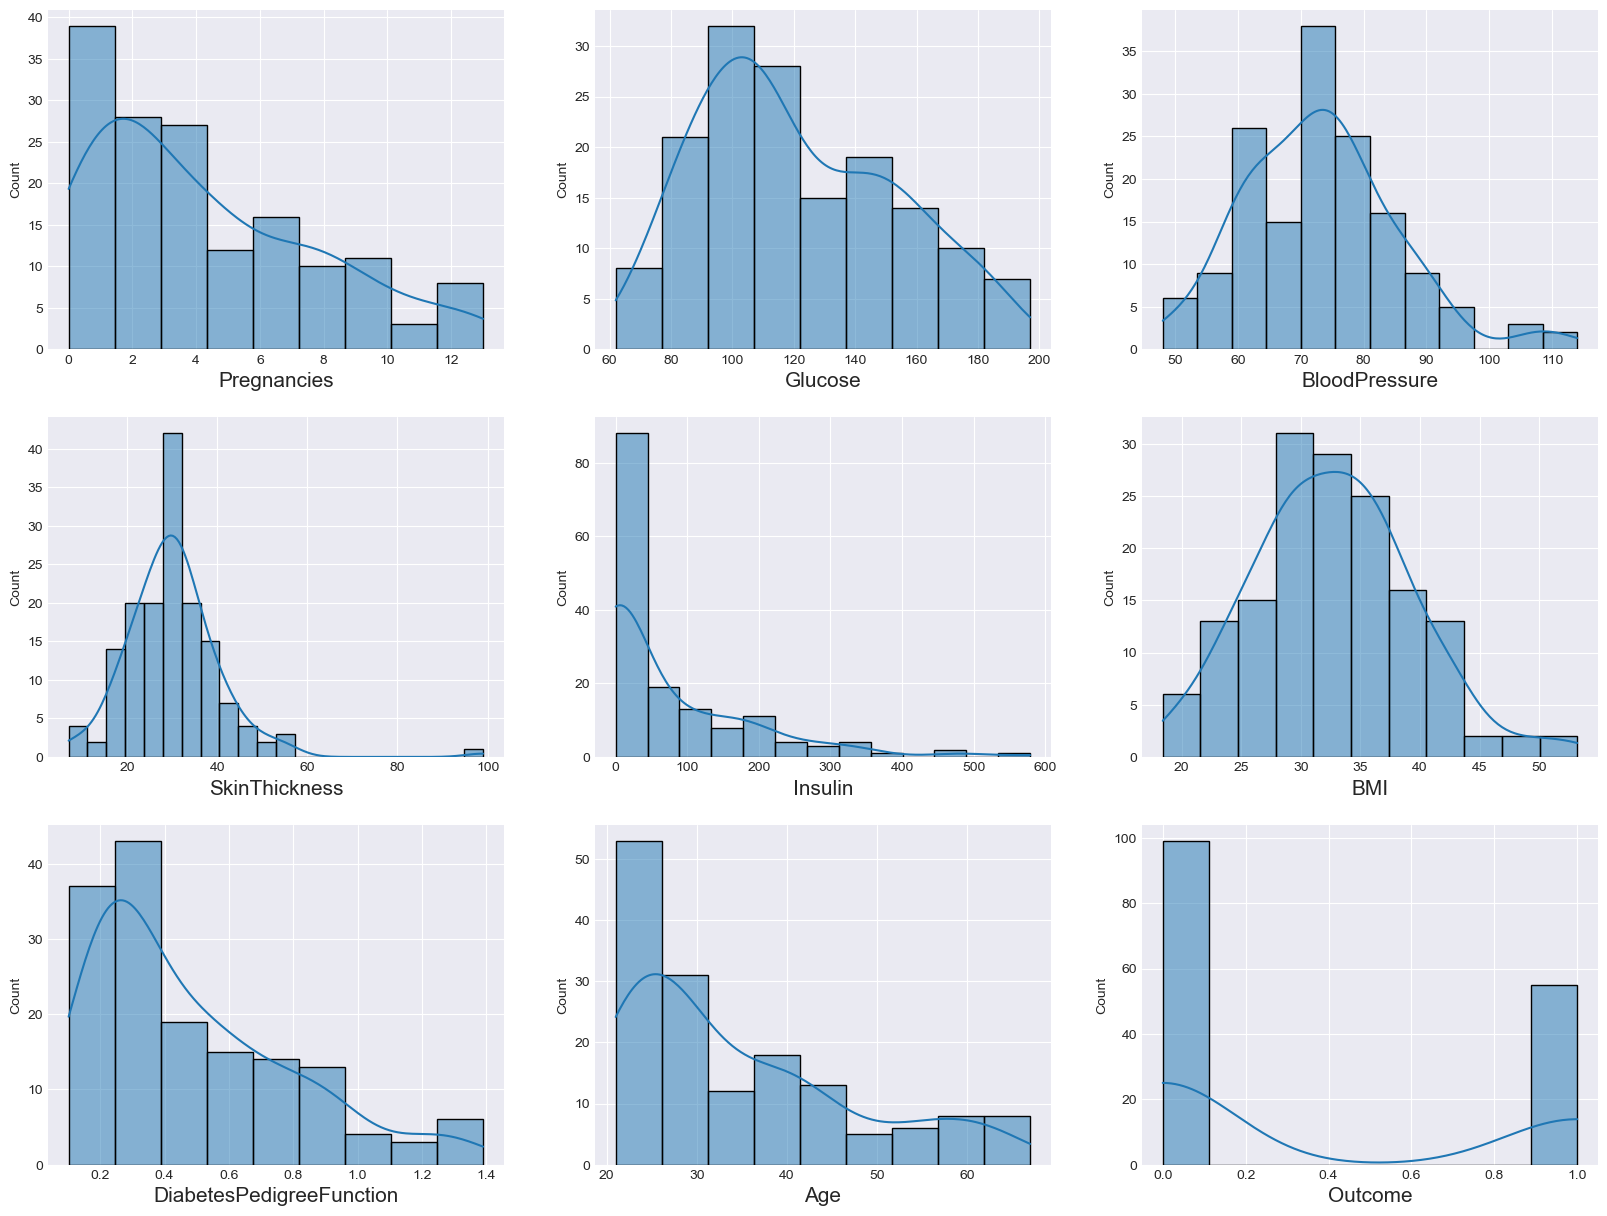

In [22]:
plt.figure(figsize = (20,15))
for i,col in enumerate(test):
    plt.subplot(3,3,i+1)
    sns.histplot(data = test, x=col, kde=True)
    plt.xlabel(col, fontsize = 15)
    plt.xticks(fontsize = 10)

In [23]:
detect_outliers(test)

,Feature,Num of Outliers,Handled?
0,Pregnancies,0,True
1,Glucose,0,True
2,BloodPressure,5,True
3,SkinThickness,4,True
4,Insulin,8,True
5,BMI,3,True
6,DiabetesPedigreeFunction,2,True
7,Age,0,True
8,Outcome,0,True


## EDA

<Axes: >

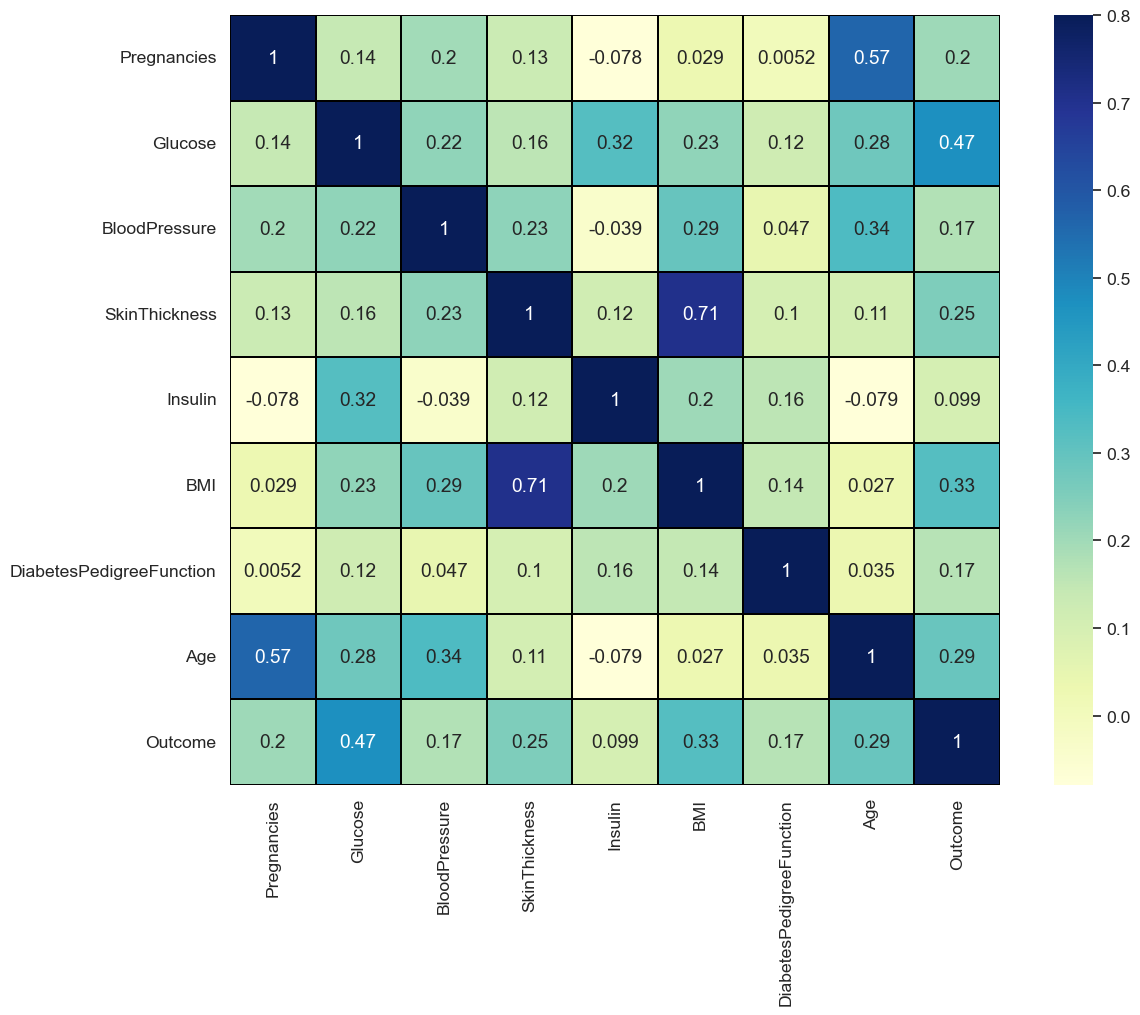

In [24]:
sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.heatmap(train.corr(),vmax=.8, linewidths=0.01, square=True,annot=True,cmap='YlGnBu',linecolor="black")

#### The only feature that shows somewhat correlation with the target column is the glocuse level

<Axes: xlabel='Outcome', ylabel='count'>

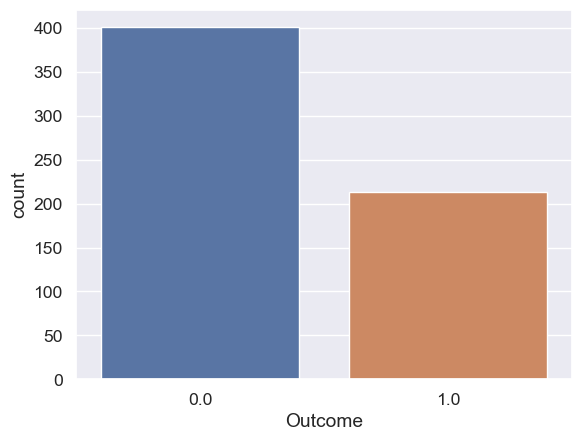

In [25]:
sns.countplot(x = 'Outcome', data = train)

#### The above graph shows that the data is biased towards datapoints having outcome value as 0 where it means that diabetes was not present actually, The number of non-diabetics is almost twice the number of diabetic patients

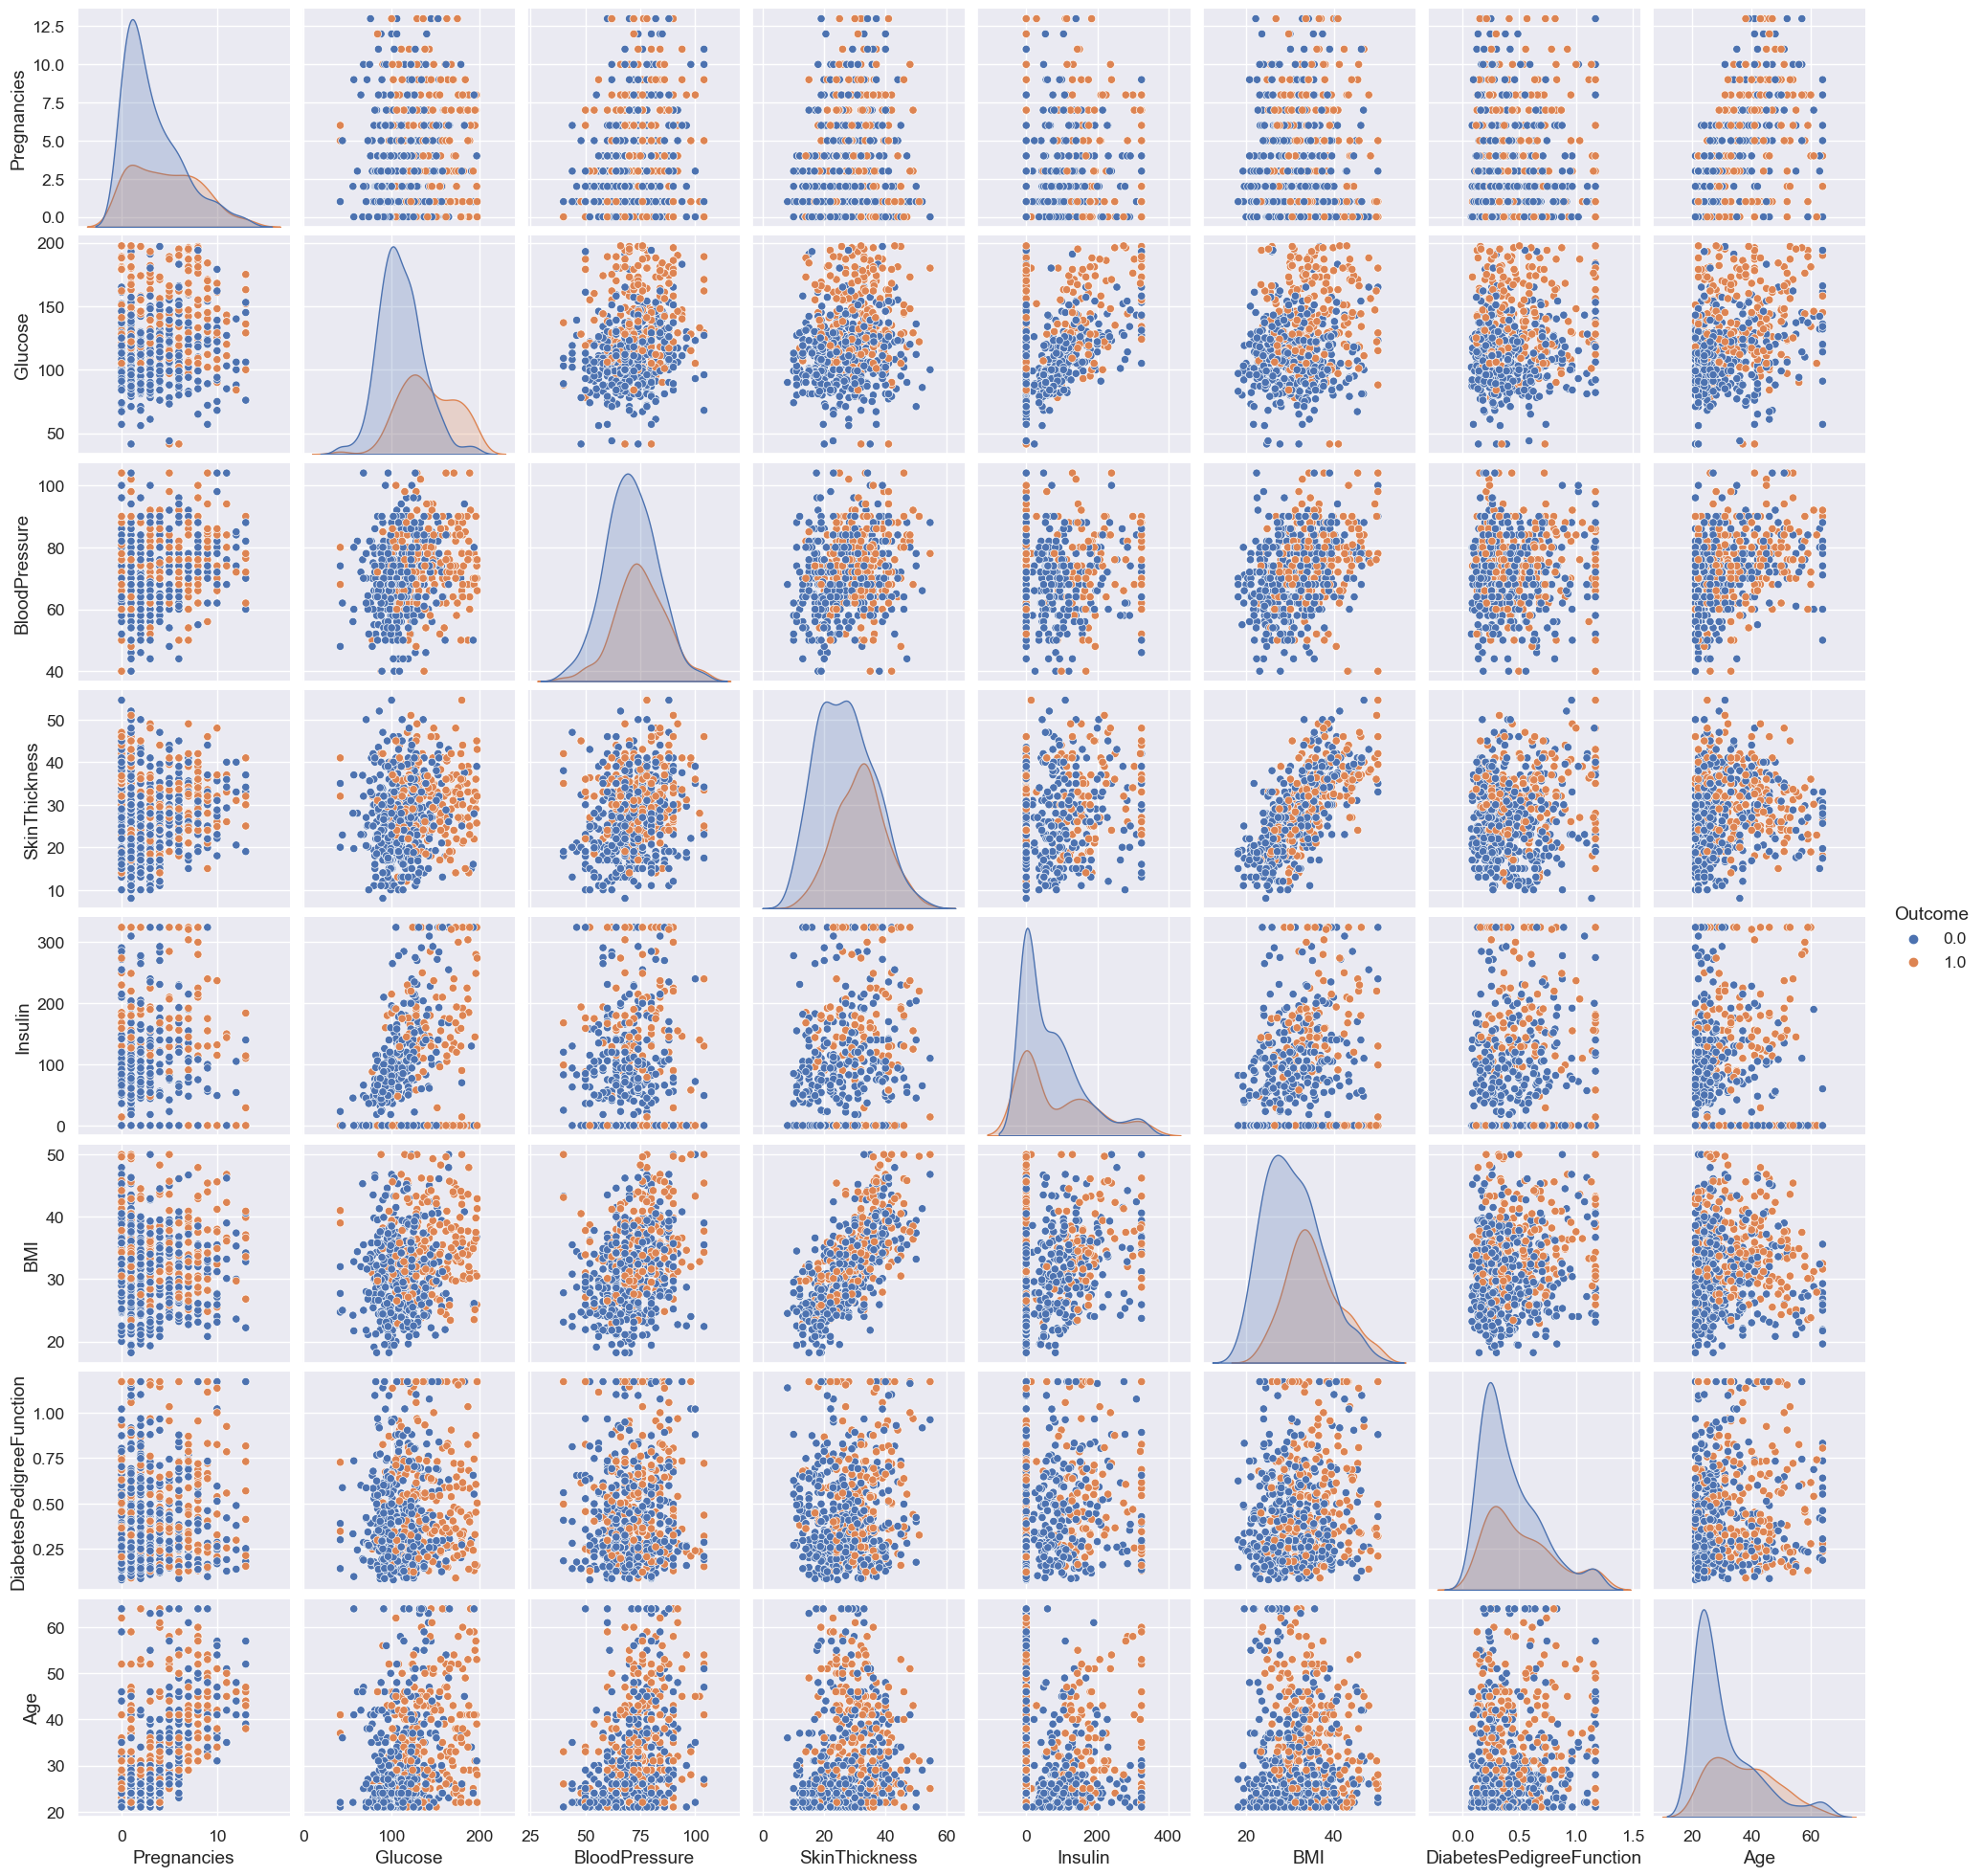

In [26]:
sns.pairplot(data = train ,hue='Outcome')

### Slicing the labels

In [27]:
x_train = train.drop('Outcome', axis = 1)
y_train = train['Outcome']
x_test = test.drop('Outcome', axis = 1)
y_test = test['Outcome']

### Scaling the data

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

## Modeling

### Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression 
log_reg = LogisticRegression( max_iter = 1000)
log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

#### Logistic regression Accuracy

In [30]:
from sklearn.metrics import accuracy_score
y_pred_l = log_reg.predict(x_test)
logistic_acc = accuracy_score(y_test, y_pred_l)
print(f'Logistic regression accuracy = {logistic_acc:.4f}')

Logistic regression accuracy = 0.7597


### Random Forest 

In [31]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 200, max_depth = 3 ,random_state = 42)
RFC.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=42)

#### Random Forest Accuracy

In [32]:
y_pred_r = RFC.predict(x_test)
rfc_acc = accuracy_score(y_test, y_pred_r)
print(f'Random forests classifier accuracy = {rfc_acc:.4f}')

Random forests classifier accuracy = 0.7792


### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 111)
KNN.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=111)

#### KNN Accuracy

In [34]:
y_pred_k = KNN.predict(x_test)
knn_acc = accuracy_score(y_test, y_pred_k) 
print(f'KNN classifier accuracy = {knn_acc:.4f}')

KNN classifier accuracy = 0.7857


### XGB

In [35]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate = 0.01, n_estimators = 25, max_depth = 2)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### XGB Accuracy

In [36]:
y_pred_x = xgb.predict(x_test)
xgb_acc = accuracy_score(y_test, y_pred_x)
print(f'XGB classifier accuracy = {xgb_acc:.4f}')

XGB classifier accuracy = 0.7662


### SVM

In [37]:
from sklearn.svm import SVC
svm = SVC(kernel= 'linear')
svm.fit(x_train,y_train)

SVC(kernel='linear')

#### SVM Accuracy

In [38]:
y_pred_s = svm.predict(x_test)
svc_acc = accuracy_score(y_test, y_pred_s)
print(f'SVM classifier accuracy = {svc_acc:.4f}')

SVM classifier accuracy = 0.7727


### Ensambling the five models

In [39]:
final_prediction = []
for i in range(len(y_test)):
    if ((y_pred_k[i] + y_pred_r[i] + y_pred_x[i] + y_pred_l[i] + y_pred_s[i]) / 5) > 0.5 :
        final_prediction.append(1)
    else :
        final_prediction.append(0)

<Axes: >

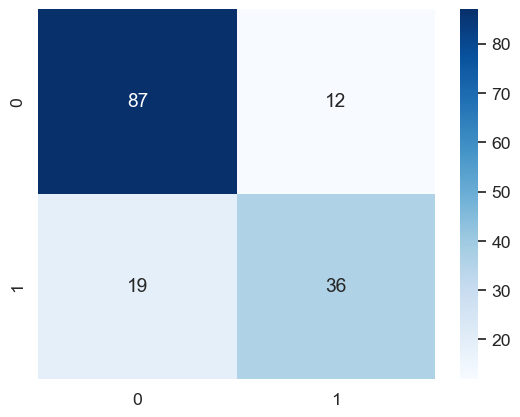

In [40]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test,final_prediction)
sns.heatmap(conf_mat , annot= True , cmap='Blues')

#### Ensambeld Accuracy

In [41]:
ensambled_acc = accuracy_score(y_test,final_prediction)
print(f'Ensambeld Accuracy = {ensambled_acc:.4f}')

Ensambeld Accuracy = 0.7987


In [42]:
from sklearn.metrics import f1_score
ensambled_f = f1_score(y_test,final_prediction)
print(f'Ensambeld f1_score = {ensambled_f:.4f}')

Ensambeld f1_score = 0.6990
